In [12]:
import os
import glob
import pandas as pd
import numpy as np

In [92]:
from textract import process

def chunk_string(string, length):
    return [string[0+i:length+i] for i in range(0, len(string), length)]

programs = glob.glob("../data/*.pdf")

text_data = {}

for program in programs:
    
    party_id = int(program.split('lijst-')[1][:2])
    
    try:
        text = process(program)
    except TypeError:
        print "Could not parse {}".format(program)
        pass
    
    if text is not None:
        
        text_data[party_id] = chunk_string(text, length=400)
        
        print "Succesfully parsed program of party {}".format(party_id)
        

Succesfully parsed program of party 18
Succesfully parsed program of party 24
Succesfully parsed program of party 5
Succesfully parsed program of party 3
Succesfully parsed program of party 2
Succesfully parsed program of party 16
Succesfully parsed program of party 7
Succesfully parsed program of party 23
Succesfully parsed program of party 8
Succesfully parsed program of party 25
Succesfully parsed program of party 1
Succesfully parsed program of party 15
Succesfully parsed program of party 17
Succesfully parsed program of party 13
Succesfully parsed program of party 11
Succesfully parsed program of party 4
Succesfully parsed program of party 9
Succesfully parsed program of party 27
Succesfully parsed program of party 14
Succesfully parsed program of party 12
Succesfully parsed program of party 20
Succesfully parsed program of party 6
Succesfully parsed program of party 10


In [89]:
# store text data in data frame
df = pd.DataFrame.from_dict(text_data, orient='index').stack().reset_index()
df.rename(columns={0: 'text'}, inplace=True)
#df['id'] = df.index.values
df['text'] = df['text'].str.normalize('NFKD')
# attach label
#df['label'] = df.apply(lambda x: 1 if x.name in positive_ids else -1, axis=1)

df.tail()

,level_0,level_1,text
2927,27,9,ze doen omdat het een roeping is. EÃ©n van de...
2928,27,10,berekend wordt. 7 miljard per jaar komt er bov...
2929,27,11,"en. Democratie\nfunctioneert momenteel niet, d..."
2930,27,12,"Robots worden in hoog tempo toegankelijker, be..."
2931,27,13,kt blijven tot een acceptabel bedrag\ndat in v...


In [102]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from nltk.corpus import stopwords

import nltk
from nltk.stem.snowball import DutchStemmer
import re

from sklearn.decomposition import LatentDirichletAllocation

def preprocess(text):
    text = text.lower()
    text = re.sub('\n',' ', text)  # remove line endings
    text = re.sub(r'[^\w\']',' ', text)  # remove non-alpha numeric
    text = re.sub(r'[0-9 ]',' ', text)
    return text

# stemmer = DutchStemmer()
# def tokenize(text):
#     """Converts text to tokens."""
#     tokens = nltk.word_tokenize(text)
#     stemmed = []
#     for item in tokens:
#         stemmed.append(stemmer.stem(item))
#     return stemmed

n_topics = 10

estimator = Pipeline(steps=[
    ('vectorizer', TfidfVectorizer(input=u'content', encoding=u'utf-8',
                                   decode_error=u'strict', strip_accents=None,
                                   lowercase=True, preprocessor=preprocess, tokenizer=None,
                                   analyzer=u'word', stop_words=stopwords.words('dutch'), 
                                   ngram_range=(1, 1), max_df=1.0, min_df=0.0, max_features=None,
                                   vocabulary=None, binary=True, dtype=np.int64,
                                   norm=u'l2', use_idf=False, smooth_idf=False, sublinear_tf=False)),
    
    ('model', LatentDirichletAllocation(n_topics=n_topics, doc_topic_prior=None, topic_word_prior=None,
                                        learning_method='batch', learning_decay=0.7, learning_offset=10.0, 
                                        max_iter=20,
                                        batch_size=128, evaluate_every=-1, total_samples=1000000.0, perp_tol=0.1,
                                        mean_change_tol=0.001, max_doc_update_iter=100, n_jobs=1, verbose=0,
                                        random_state=None))])

estimator.fit_transform(df['text'].values)
estimator

Pipeline(steps=[('vectorizer', TfidfVectorizer(analyzer=u'word', binary=True, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=0.0,
        ngram_range=(1, 1), norm=u'l2',
        preprocessor=<funct...ol=0.1, random_state=None,
             topic_word_prior=None, total_samples=1000000.0, verbose=0))])

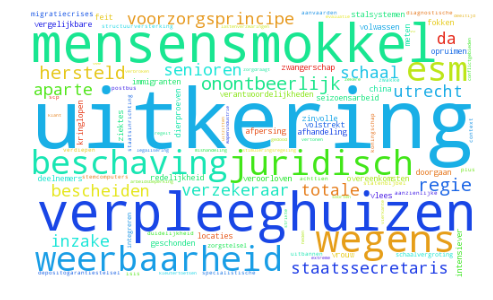

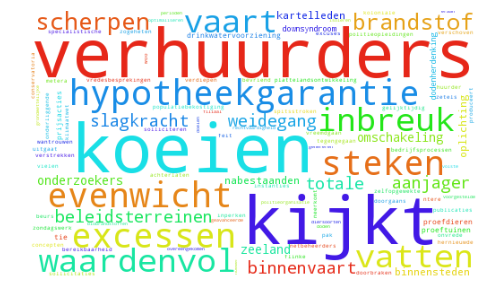

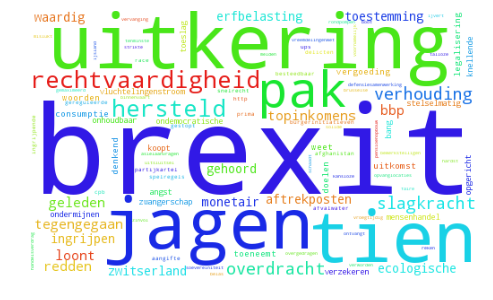

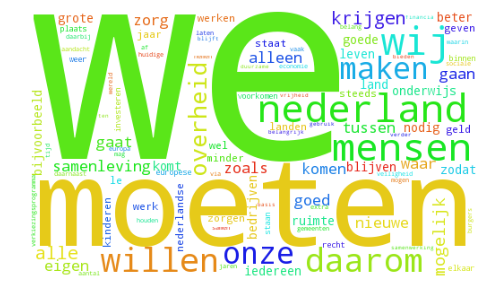

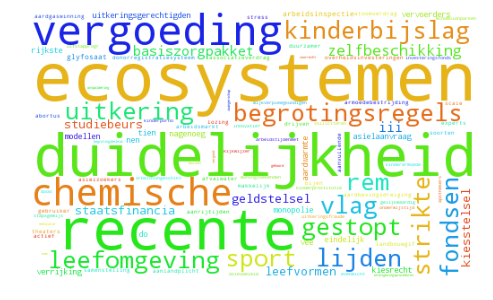

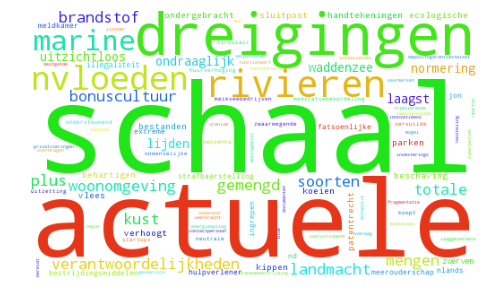

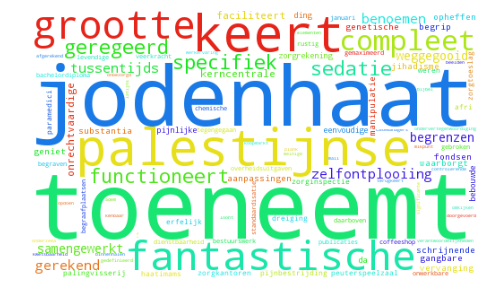

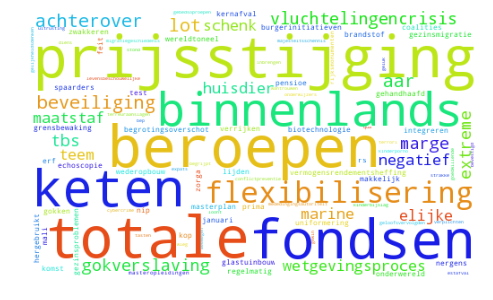

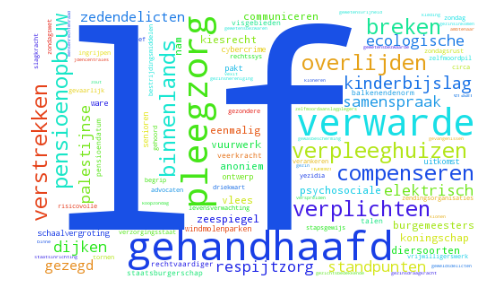

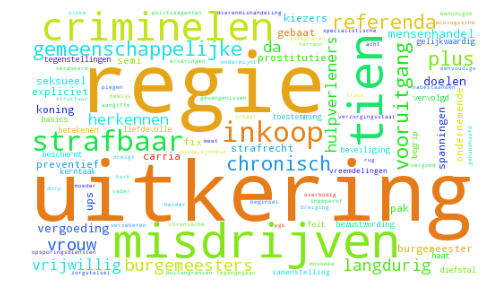

In [103]:
from wordcloud import WordCloud 
import matplotlib.pyplot as plt
%matplotlib inline

def plot_word_cloud(words, components, n_top_words=3):   
    for topic_idx, weights in enumerate(components):
        wc = WordCloud(background_color="white", max_words=100, width=500, height=300)
        wc.generate_from_frequencies(zip(words, weights))
        plt.figure(figsize=(8,6))
        plt.imshow(wc)
        plt.axis("off")
        plt.show()
    
words = estimator.steps[0][1].get_feature_names()
components = estimator._final_estimator.components_

plot_word_cloud(words, components)